## Background
**NFL Pre-Snap Play-By-By (home team) Win Probability Using Random Forest**

<br>

**Data:**
https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016#NFL%20Play%20by%20Play%202009-2018%20(v5).csv
<br>

**Reference:** <br>
Lock, D. & Nettleton, D. (2014). Using random forests to estimate win probability <br> before each play of an NFL game. *Journal of Quantitative Analysis in Sports*, 10(2), <br> pp. 197-205. Retrieved 11 Feb. 2020, from doi:10.1515/jqas-2013-0100



In [1]:
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_full = pd.read_csv('NFL Play by Play 2009-2018 (v5).csv', low_memory=False)
df_full.shape

(449371, 255)

***

### Pre-Processing

In [3]:
def column_search(column_string):
    for i in list(zip(df_full.columns,df_full.dtypes)):
        if re.search(str(column_string),i[0]):
            print(i)

In [4]:
pd.set_option('display.max_columns', None)
df_full.tail()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,receiver_player_id,receiver_player_name,rusher_player_id,rusher_player_name,lateral_receiver_player_id,lateral_receiver_player_name,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackl

In [5]:
%%time
df_full['Unique Play ID'] = df_full[['game_id', 'play_id']].apply(lambda x: ''.join(x.astype('str')), axis=1)

CPU times: user 58.8 s, sys: 139 ms, total: 58.9 s
Wall time: 59 s


In [6]:
%%time
from collections import Counter

id_counts = Counter(df_full['Unique Play ID'])
duplicates = []
for k,v in id_counts.items():
    if id_counts[k] > 1:
        duplicates += [k]


CPU times: user 267 ms, sys: 11.8 ms, total: 278 ms
Wall time: 277 ms


In [7]:
len(duplicates)

2413

In [8]:
df_full.loc[df_full['Unique Play ID'].isin(duplicates)].sort_values('Unique Play ID')

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,receiver_player_id,receiver_player_name,rusher_player_id,rusher_player_name,lateral_receiver_player_id,lateral_receiver_player_name,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackl

In [9]:
df_full = df_full.drop_duplicates('Unique Play ID')
df_full.shape

(446934, 256)

In [10]:
game_df = df_full.groupby(['game_id']).agg({'home_team': 'min', 'away_team': 'min', 'game_date': 'min',
                                            'total_home_score': 'max', 'total_away_score': 'max'})

game_df['Home_Team_Win'] = np.where(game_df.total_home_score > game_df.total_away_score, 1,
                                      (np.where(game_df.total_home_score < game_df.total_away_score, 0, 2)))

game_df.reset_index(inplace = True)

game_df.head()

,game_id,home_team,away_team,game_date,total_home_score,total_away_score,Home_Team_Win
0,2009091000,PIT,TEN,2009-09-10,13,10,1
1,2009091300,ATL,MIA,2009-09-13,19,7,1
2,2009091301,BAL,KC,2009-09-13,38,23,1
3,2009091302,CAR,PHI,2009-09-13,10,36,0
4,2009091303,CIN,DEN,2009-09-13,7,12,0


##### Home Team Results

- Win (1): 1439
- Loss (0): 1073
- Tie (2): 14

In [11]:
game_df.Home_Team_Win.value_counts()

1    1439
0    1073
2      14
Name: Home_Team_Win, dtype: int64

In [12]:
relevant_columns = ['Unique Play ID','game_id','posteam_type','total_home_score', 
                    'total_away_score','game_seconds_remaining', 'down', 'ydstogo',
                    'yardline_100', 'home_wp', 'away_wp', 'home_timeouts_remaining', 'away_timeouts_remaining'] 

df = df_full.loc[:,relevant_columns]

#Add Home Team Win/Loss Result To Plays
df = pd.merge(df, game_df[['game_id', 'Home_Team_Win']], on='game_id', how='left')

df['posteam_type'] = np.where(df['posteam_type'] == 'home', 1,0)

df = df.loc[(df.Home_Team_Win == 1) | (df.Home_Team_Win == 0), ] #Exclude Ties

df.isnull().sum()

Unique Play ID                 0
game_id                        0
posteam_type                   0
total_home_score               0
total_away_score               0
game_seconds_remaining       160
down                       67129
ydstogo                        0
yardline_100               12907
home_wp                    13809
away_wp                    13809
home_timeouts_remaining        0
away_timeouts_remaining        0
Home_Team_Win                  0
dtype: int64

In [13]:
null_drops = df.loc[(df.game_seconds_remaining.isnull()) | (df.yardline_100.isnull()) | (df.down.isnull())
                            | (df.home_wp.isnull() | (df.posteam_type.isnull())),].index

df = df.drop(null_drops)

In [14]:
df.isnull().sum()

Unique Play ID             0
game_id                    0
posteam_type               0
total_home_score           0
total_away_score           0
game_seconds_remaining     0
down                       0
ydstogo                    0
yardline_100               0
home_wp                    0
away_wp                    0
home_timeouts_remaining    0
away_timeouts_remaining    0
Home_Team_Win              0
dtype: int64

In [15]:
df.shape

(376595, 14)

In [16]:
play_ids_tokeep = df['Unique Play ID'].values
df_full = df_full.loc[df_full['Unique Play ID'].isin(play_ids_tokeep),]

df_full.shape #Sanity Check

(376595, 256)

In [17]:
import random

random.seed(7000) #random Games for test samples
test_games = random.choices(list(game_df.game_id), k=5)


#Test Games
test_games_df = game_df.loc[game_df.game_id.isin(test_games)]
test_games_df

,game_id,home_team,away_team,game_date,total_home_score,total_away_score,Home_Team_Win
146,2009112201,DAL,WAS,2009-11-22,7,6,1
565,2011100205,CHI,CAR,2011-10-02,32,29,1
814,2012092313,BAL,NE,2012-09-23,31,30,1
857,2012101411,HOU,GB,2012-10-14,23,42,0
1334,2014092806,OAK,MIA,2014-09-28,14,37,0


In [18]:
df['Score_Difference'] = df.total_home_score - df.total_away_score
df['Score_Adjusted'] = (df.Score_Difference)/ np.sqrt(df.game_seconds_remaining + 1)

In [19]:

clf_vars = ['posteam_type', 'Score_Difference', 'Score_Adjusted', 
            'down', 'ydstogo', 'home_timeouts_remaining', 'away_timeouts_remaining',
            'yardline_100','Home_Team_Win']

display(df[clf_vars].corr())

train_x = df.loc[~df.game_id.isin(test_games), clf_vars]
train_y = train_x['Home_Team_Win'].values
train_x = train_x.drop('Home_Team_Win', axis=1).values

test_x = df.loc[df.game_id.isin(test_games), clf_vars]
test_y = test_x['Home_Team_Win'].values
test_x = test_x.drop('Home_Team_Win', axis=1).values

clf_plays = df_full.loc[df_full.game_id.isin(test_games),]

,posteam_type,Score_Difference,Score_Adjusted,down,ydstogo,home_timeouts_remaining,away_timeouts_remaining,yardline_100,Home_Team_Win
posteam_type,1.000000,-0.093087,-0.080519,-0.008554,-0.004031,-0.012471,0.013041,-0.024239,0.013879
Score_Difference,-0.093087,1.000000,0.747503,0.000595,0.000450,-0.009713,-0.009966,-0.001233,0.536441
Score_Adjusted,-0.080519,0.747503,1.000000,0.003595,0.000985,0.031957,-0.092616,-0.002450,0.408610
down,-0.008554,0.000595,0.003595,1.000000,-0.244320,-0.019686,-0.026264,-0.049730,-0.001089
ydstogo,-0.004031,0.000450,0.000985,-0.244320,1.000000,-0.002985,-0.005630,0.225591,-0.001999
home_timeouts_remaining,-0.012471,-0.009713,0.031957,-0.019686,-0.002985,1.000000,0.320951,0.061330,0.009469
away_timeouts_remaining,0.013041,-0.009966,-0.092616,-0.026264,-0.005630,0.320951,1.000000,0.053858,-0.011126
yardline_100,-0.024239,-0.001233,-0.002450,-0.049730,0.225591,0.061330,0.053858,1.000000,-0.001325
Home_Team_Win,0.013879,0.536441,0.408610,-0.001089,-0.001999,0.009469,-0.011126,-0.001325,1.000000


***

### Modeling
###### Random Forest Regressor

In [20]:
%%time
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=500, min_samples_leaf= 200)
clf.fit(train_x,train_y)
predictions = clf.predict(test_x)

CPU times: user 4min 54s, sys: 887 ms, total: 4min 55s
Wall time: 4min 55s


***

### Evaluation

In [21]:
test_plays = clf_plays.copy()
test_plays['Home_Model_Percent'] = predictions
test_plays['Away_Model_Percent'] = 1 - predictions

$$ MSE\: (Mean\:Squared\:Error)= \frac{1}{N}\sum_{i=1}^N{(\hat{y}_i-y_i)^2}$$

In [22]:
def mse(_y, _y_pred):
    return (len(_y)**-1) * np.sum((_y_pred-_y)**2)

print(f" MSE: {mse(clf_plays.home_wp, predictions)}")


#Most Valuable Predictors
pd.DataFrame(zip(clf_vars[:-1],clf.feature_importances_), 
             columns=['Variable', 'Feature Score']).sort_values('Feature Score', ascending=False)

 MSE: 0.0046728476878670445


,Variable,Feature Score
2,Score_Adjusted,0.903571
1,Score_Difference,0.041395
7,yardline_100,0.023092
0,posteam_type,0.016579
3,down,0.005617
4,ydstogo,0.003405
6,away_timeouts_remaining,0.003210
5,home_timeouts_remaining,0.003131


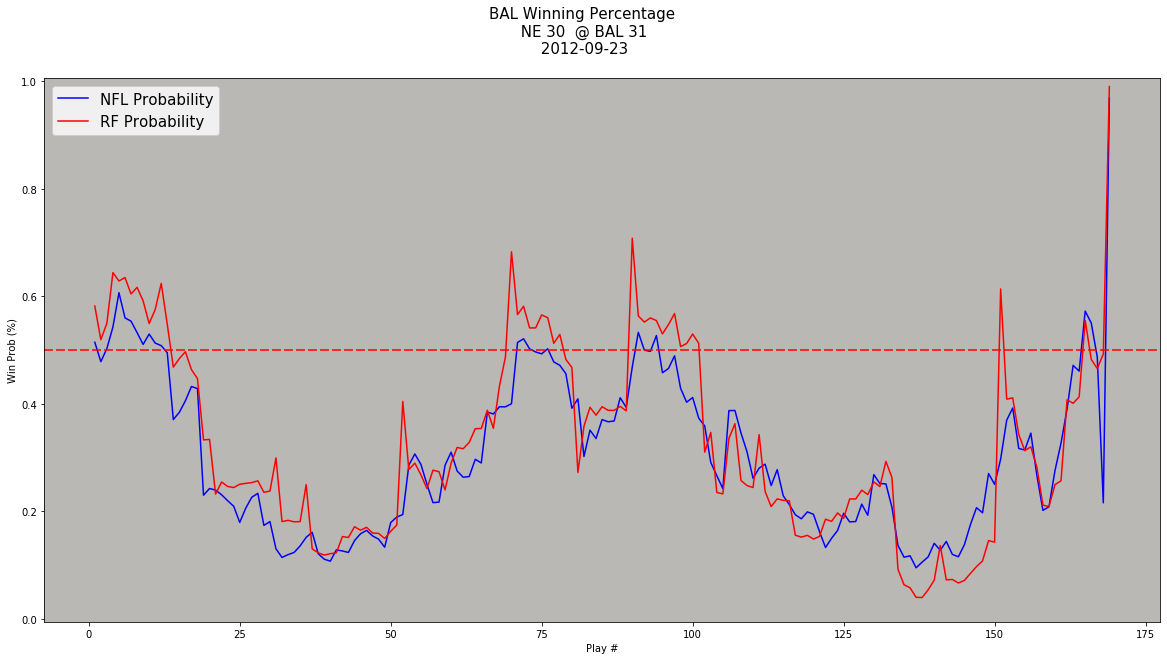

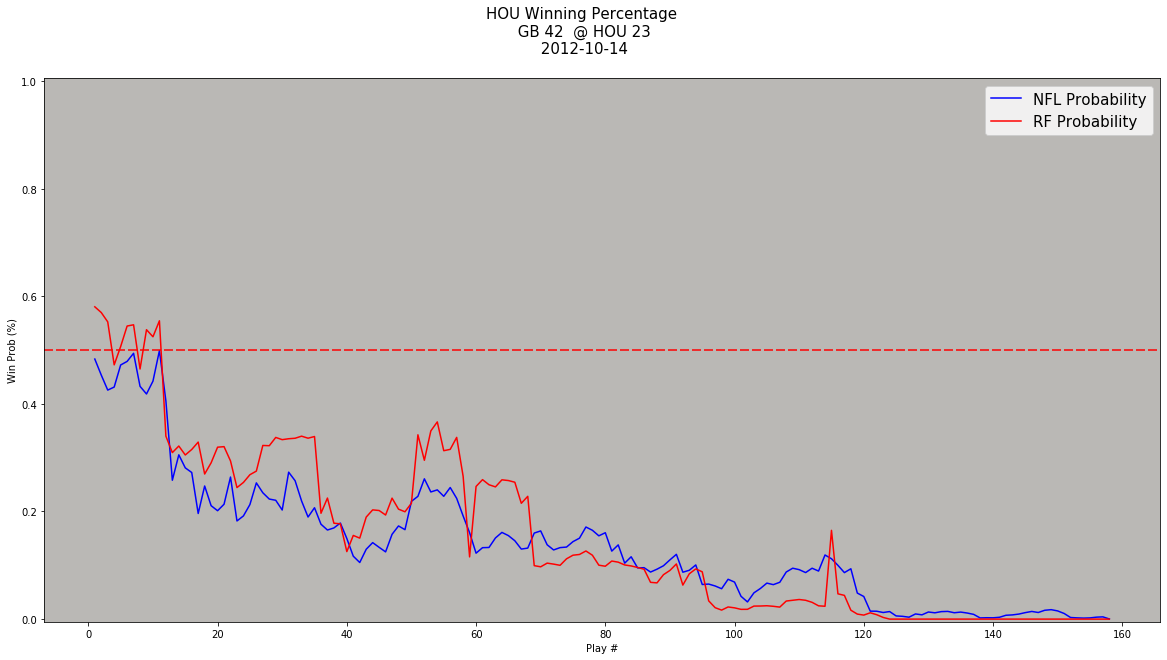

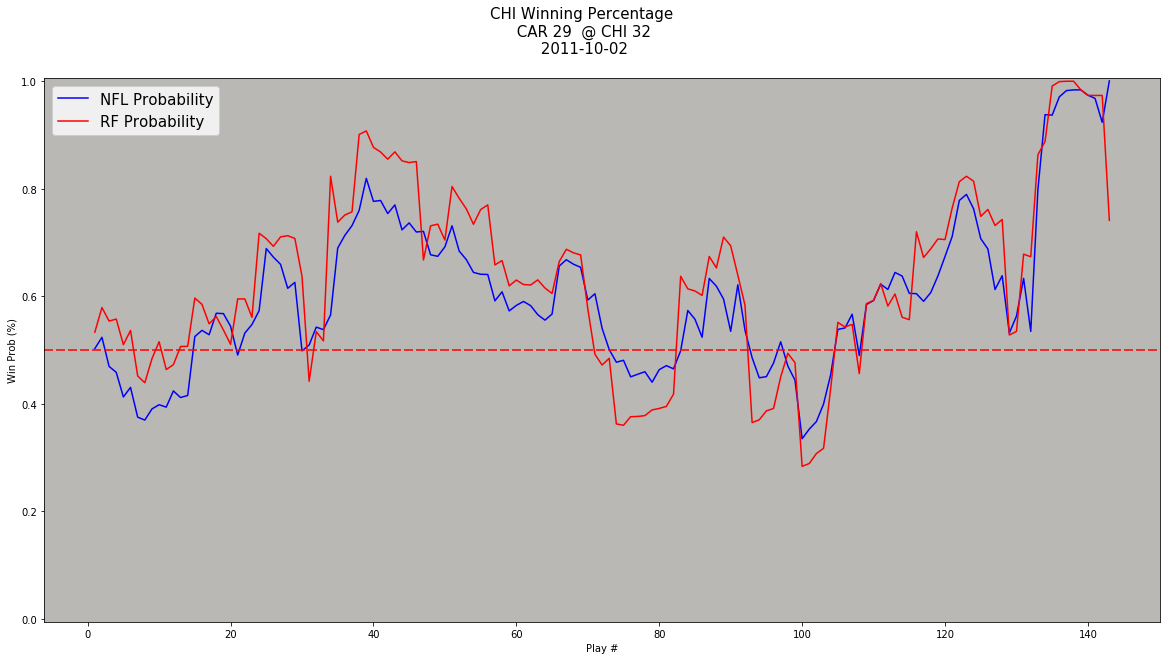

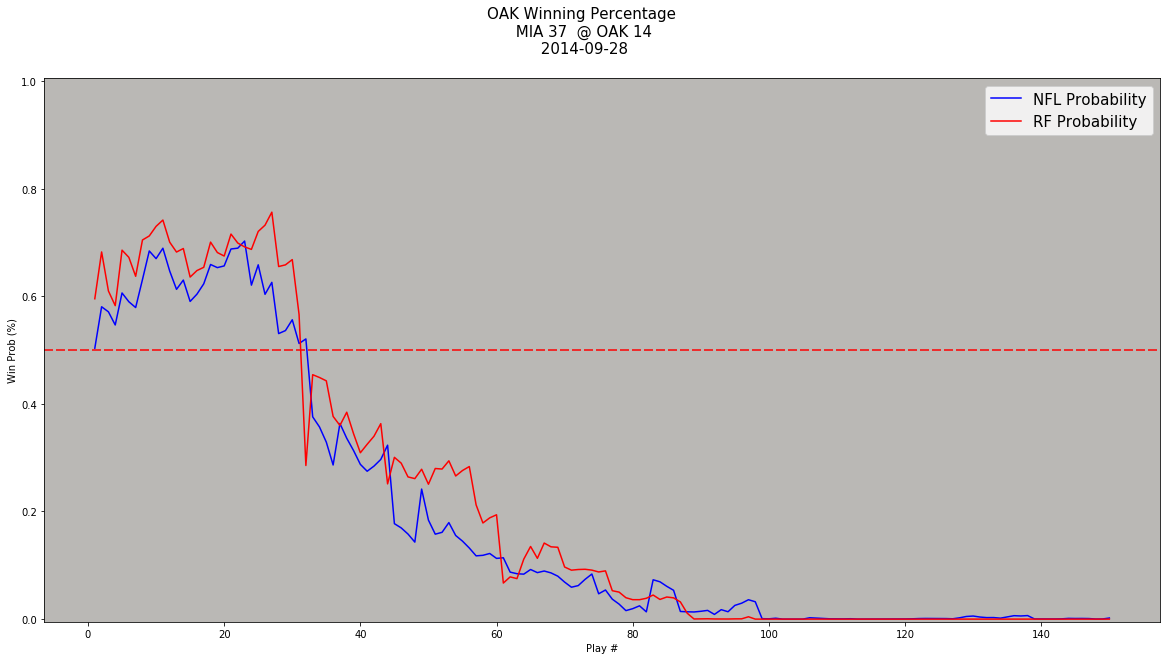

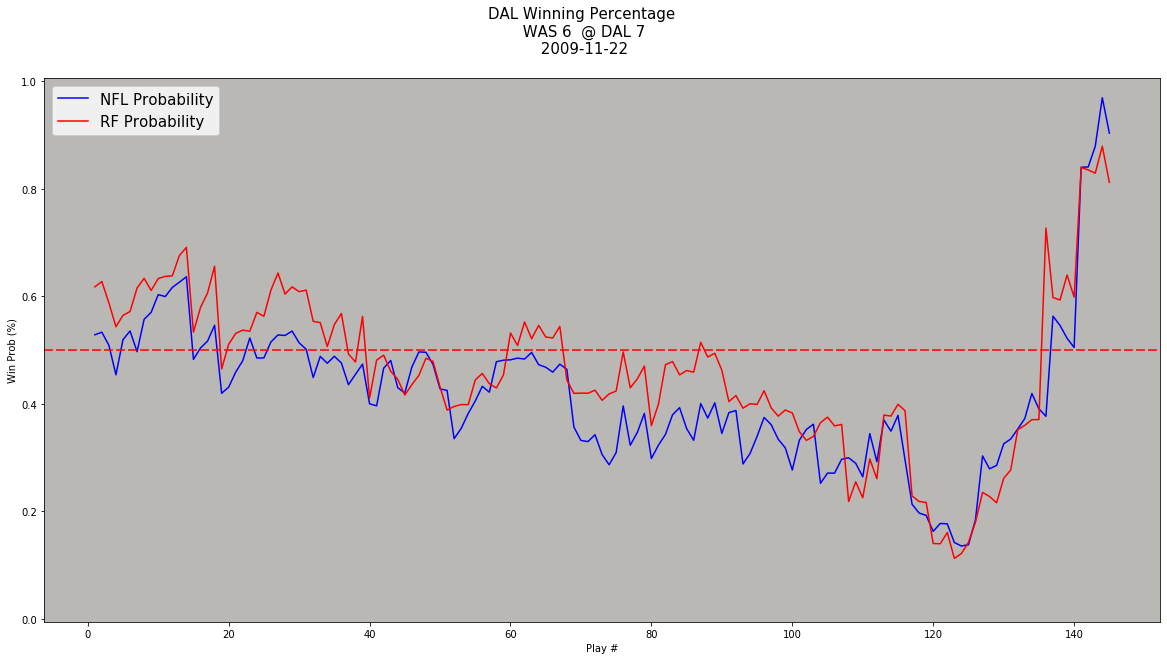

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt


for game in test_games:
    
    #Game and Play DataFrame For Test Data
    df_ = test_games_df[test_games_df.game_id == game]
    play_df_ = test_plays[test_plays.game_id == game]
    
    #Game and Play Info
    date_, home_, away_,  = df_.game_date.item(), df_.home_team.item(), df_.away_team.item()
    home_points_, away_points_ =  df_.total_home_score.item(), df_.total_away_score.item()
    
    #X Data... Number of Plays
    plt_x = np.arange(1,play_df_.shape[0] + 1)
    
    #Given NFL Probability
    plt_y1 =  play_df_.home_wp
    #Random Forrest Model Probability
    plt_y2 = play_df_.Home_Model_Percent
    
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(plt_x, plt_y1, color = 'blue', label = 'NFL Probability')
    ax.plot(plt_x, plt_y2, color = 'red', label= 'RF Probability')
    ax.set_ylim(-.005, 1.005)
    ax.set(xlabel = 'Play #', ylabel = 'Win Prob (%)')
    ax.axhline(y=0.5, xmin=0.0, xmax=1.0, color='r', dashes=[6, 2])
    ax.set_facecolor('#bab8b5')
    ax.legend(prop={'size': 15})
    
    #Plot Title 
    fig.suptitle(f'{home_} Winning Percentage \n {away_} {away_points_}  @ {home_} {home_points_} \n {date_} \n ', fontsize=15)
    
#     print()